# Image Inpainting - Shahan Nedadahandeh - snedadah@uwaterloo.ca

## Abstract

Image inpainting is an important problem in computer vision. Its is rather challening, since not only do we need to understand the contents of the image, we need to actually undersand the context of the image to be able to correctly fill in a missing part. 

In this project, we implement a version of image inpaining inspired by the paper Context Encoders by Deepak Pathek et al.. We build an autoencoder struture, where we encode images into a latent space that respects the "context" of the image, and then decode it geneerating the inpainted section. We notice similar problems that the authors of the papers noticed, with the L2 loss funciton leading to blurry inpainting results. However, instead of taking the approach outlined in their paper of using an adversarial networl to prove an adverserial loss, we invesitage alternate approaches to get rid of the blurring, such as expermingin with different loss functions that pay more attention to the structure of the image, such as SSIM, creating a custom loss based on image gradients to detect edges and constrcut a loss based on that. 

Furthermore, we inversitate out the latent space of our context encoder differs from the latent space of resnet by visulizing the high dimensional latent space using a principle component analyusis, and find that the latent space is meaningfully different, which explains why we intitialyl couldn't generate inpaintings using just the encoder from resnet.


// TODO: talk about black hole in the center of the image



### Code Libraries
PyTorch - Used for autoencoder trainin

TorchVision - Used for image transformations and data loading

MatPlotLib - Used for visulziations

Pytorch_SSIM - Used for implementing the SSIM loss function as part of one of our experiments.

SkLearn - For principal component analysis 

tqdm - Used for displaying progress bars when training


In [10]:
import torch
import torchvision.transforms as T
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os
import sys
from PIL import Image
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm
from pytorch_ssim import pytorch_ssim

### Dataset Download

In [11]:
## The dataset we use is the imagenet dataset
# You can download the dataset using the command: kaggle competitions download -c imagenet-object-localization-challenge

# Update the following variable with your dataset location
DATASET_PATH = '/pub2/imagenet/ILSVRC/Data/CLS-LOC/train'

In [12]:
IMAGE_SIZE = 128 # Size of images fed into the model, we make the images smaller so we can train smaller and quicker models, our results should extend with bigger images as well
CENTER_SIZE = 64 # The amount of
BATCH_SIZE = 500



# The imagenet dataset has over a thousdan different classes. To train a model that works well with all clases would take more time and computation resoruces that we had avarible for this project. So we restrict our model to only work with the fruit classes. There are still different enough classes that our model can meaningfully learn to infill different types of object, while at the same time there are few categories, so we need less training time for our model.

SELECTED_CLASSES =  {
            # 858: "Tile Roof", # Tile Roof
						# 937: "Broccoli", 
						# 980: "Volcano",
						987: "Corn",
						949: 'Strawberry',
						948: "Apple",
						954: "Banana",
						953: "Pineapple",
						951: "Lemon",
						950: 'Orange',
						967: 'Pomegranate'
}

# Utils

The following are some utility methods that will be helpful later in our code.

In [63]:
import math
def display_image(img):
        with torch.no_grad():
                img = img.permute((1, 2, 0))
                plt.imshow(img.cpu().numpy())
                plt.show()

def display_images(imgs, images_per_row=2, title=None):
        with torch.no_grad():
                rows = math.ceil(len(imgs) / images_per_row)
                fig = plt.figure(figsize=(images_per_row*2, rows*2))
                if title:
                        fig.suptitle(title, fontsize=10)
                for i, img in enumerate(imgs):
                        plt.subplot(rows, images_per_row, i+1)
                        plt.axis('off')
                        plt.tight_layout()
                        img = img.permute((1, 2, 0))
                        plt.imshow(img.cpu().numpy())
                plt.show()

def get_center_of_image(img, size=64):
        return T.CenterCrop((size, size))(img)

def get_img_without_center(img):
        left = (IMAGE_SIZE - CENTER_SIZE) // 2
        right = (IMAGE_SIZE - CENTER_SIZE) // 2 + CENTER_SIZE
        if(len(img.shape) == 3):
                img[ :, left:right, left:right ] = 0
        elif(len(img.shape) == 4):
                img[:, :, left:right, left:right ] = 0
        else:
                raise RuntimeError("Wrong shape to get_img_without_center!")
                
        return img

class CenterImageRemoval(object):
    def __init__(self, image_size, center_size):
        self.image_size = image_size
        self.center_size = center_size
        
    def __call__(self, img):
        left = (self.image_size - self.center_size) // 2
        right = (self.image_size - self.center_size) // 2 + self.center_size

        if(len(img.shape) == 3):
                assert img.shape[1] == img.shape[2] == self.image_size
                img[ :, left:right, left:right ] = 0
        elif(len(img.shape) == 4):
                assert img.shape[2] == img.shape[3] == self.image_size
                img[:, :, left:right, left:right ] = 0

        return img

class AddImageCenter(object):
    def __init__(self, image_size, center_size):
        self.image_size = image_size
        self.center_size = center_size
        
    def __call__(self, img, center):
        assert center.shape[1] == center.shape[2] == self.center_size

        left = (self.image_size - self.center_size) // 2
        right = (self.image_size - self.center_size) // 2 + self.center_size

        if(len(img.shape) == 3):
                assert img.shape[1] == img.shape[2] == self.image_size
                img[ :, left:right, left:right ] = center
        elif(len(img.shape) == 4):
                assert img.shape[2] == img.shape[3] == self.image_size
                img[:, :, left:right, left:right ] = center
        return img

class JointRandomResizeCrop(object):
    def __init__(self, size: int, minimum_scale, maximum_scale):
        """
        params:
            size (int) : size of the center crop
        """
        self.size = size
        self.min_scale = minimum_scale
        self.max_scale = maximum_scale
        
    def __call__(self, img, target):
        scale = (self.max_scale - self.min_scale)*random.random() + self.min_scale
        _, height, width = img.shape
        new_h, new_w = int(height*scale), int(width*scale)

        target = target.reshape((1, height, width))
        resized_img = T.functional.resize(img,  [new_h, new_w])
        resized_target = T.functional.resize(target, [new_h, new_w])
        crop_size = min(self.size, new_h, new_w)
        top = random.randint(0, new_h - crop_size)
        left = random.randint(0, new_w - crop_size)
        resized_img = T.functional.crop(resized_img, top, left, crop_size, crop_size)
        resized_target = T.functional.crop(resized_target, top, left, crop_size, crop_size)

        resized_img = T.functional.resize(resized_img, size=(self.size, self.size))
        resized_target = T.functional.resize(resized_target, size=(self.size, self.size))
        resized_target = resized_target.reshape((self.size, self.size))

        return (resized_img, resized_target)
    
def save_model(encoder, decoder, epoch, optimizer, path):
	state = {
    'epoch': epoch,
    'encoder': encoder.state_dict(),
    'decoder': decoder.state_dict(),
    'optimizer': optimizer.state_dict(),
	}
	torch.save(state, path)


def load_model(encoder, decoder, optimizer, path):
	state = torch.load(path)
	encoder.load_state_dict(state["encoder"])
	decoder.load_state_dict(state["decoder"])
	optimizer.load_state_dict(state["optimizer"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloading

We split our dataset into 3 splits.

- Training: 90% of the data, used for training the model
- Validation: 10% of the data, used for validation
- Sanity: A single image, used for sanity checking our modelCustomDataSet


We create a custom PyTorch DataSet (`CustomDataSet`) class, that supports the special transformtion we want to apply to images (blackening the middle) but not the ground truth.

In [14]:
train_tranforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.RandomHorizontalFlip(p=0.5),
    T.ConvertImageDtype(torch.float32),
])

val_tranforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32),
])

# extra transformation not applied to ground truth images (removing the center of the image)
non_gt_extra_transforms = T.Compose([
    CenterImageRemoval(IMAGE_SIZE, CENTER_SIZE),
])

sanity_transforms = T.Compose([
    T.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.CenterCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.ConvertImageDtype(torch.float32),
])

In [15]:
class CustomDataSet(Dataset):
    def __init__(self, root_dir, classes, transform=None, non_gt_extra_transforms=None, training_split=0.8, is_train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.non_gt_extra_transforms = non_gt_extra_transforms

        selected_class_indexes = list(classes.keys())
        dirs = np.array(sorted(os.listdir(root_dir)))[selected_class_indexes]

        self.images = []
        self.cache = {}

        self.is_train = is_train
        for i, dir in enumerate(dirs):
            imgs = sorted(os.listdir(os.path.join(self.root_dir, dir)))
            train_split = int(len(imgs)*training_split)
            if is_train:
                imgs = imgs[0:train_split]
            else:
                imgs = imgs[train_split:]
            for img in imgs:
                self.images.append((os.path.join(self.root_dir, dir, img), selected_class_indexes[i]))
    

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name, class_label = self.images[idx]
        image = None

        if img_name not in self.cache:
            self.cache[img_name] = Image.open(img_name).convert('RGB')
        image = self.cache[img_name]


        if self.transform:
            transformed_image = self.transform(image)
        else:
            transformed_image = None

        gt_image = torch.clone(transformed_image)

        if non_gt_extra_transforms:
            transformed_image = non_gt_extra_transforms(transformed_image)

        return transformed_image, gt_image, class_label


# Due to the way the dataset is strucutred, I can't use the offical validation images provided
# Therefore, I'm splitting the provided training_split from the dataset, 90% for training, and 10% for validation
train_dataset = CustomDataSet(root_dir=DATASET_PATH, 
                                      transform=train_tranforms, 
                                      non_gt_extra_transforms=non_gt_extra_transforms,
                                      classes=SELECTED_CLASSES,
                                      is_train=True,
                                      training_split=0.9
                                      )
validation_dataset = CustomDataSet(root_dir=DATASET_PATH, 
                                      transform=val_tranforms, 
                                      non_gt_extra_transforms=non_gt_extra_transforms,
                                      classes=SELECTED_CLASSES,
                                      is_train=False
                                      )

# Like the training dataset but only has 1 image
sanity_dataset = CustomDataSet(root_dir=DATASET_PATH, 
                                      transform=sanity_transforms, 
                                      non_gt_extra_transforms=non_gt_extra_transforms,
                                      classes=SELECTED_CLASSES,
                                      is_train=True,
                                      training_split=0.9
                                      )
sanity_dataset = torch.utils.data.Subset(sanity_dataset, [1])


In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
sanity_loader = DataLoader(sanity_dataset, batch_size=1, shuffle=True)

 ## Sample batch of training and ground truth images

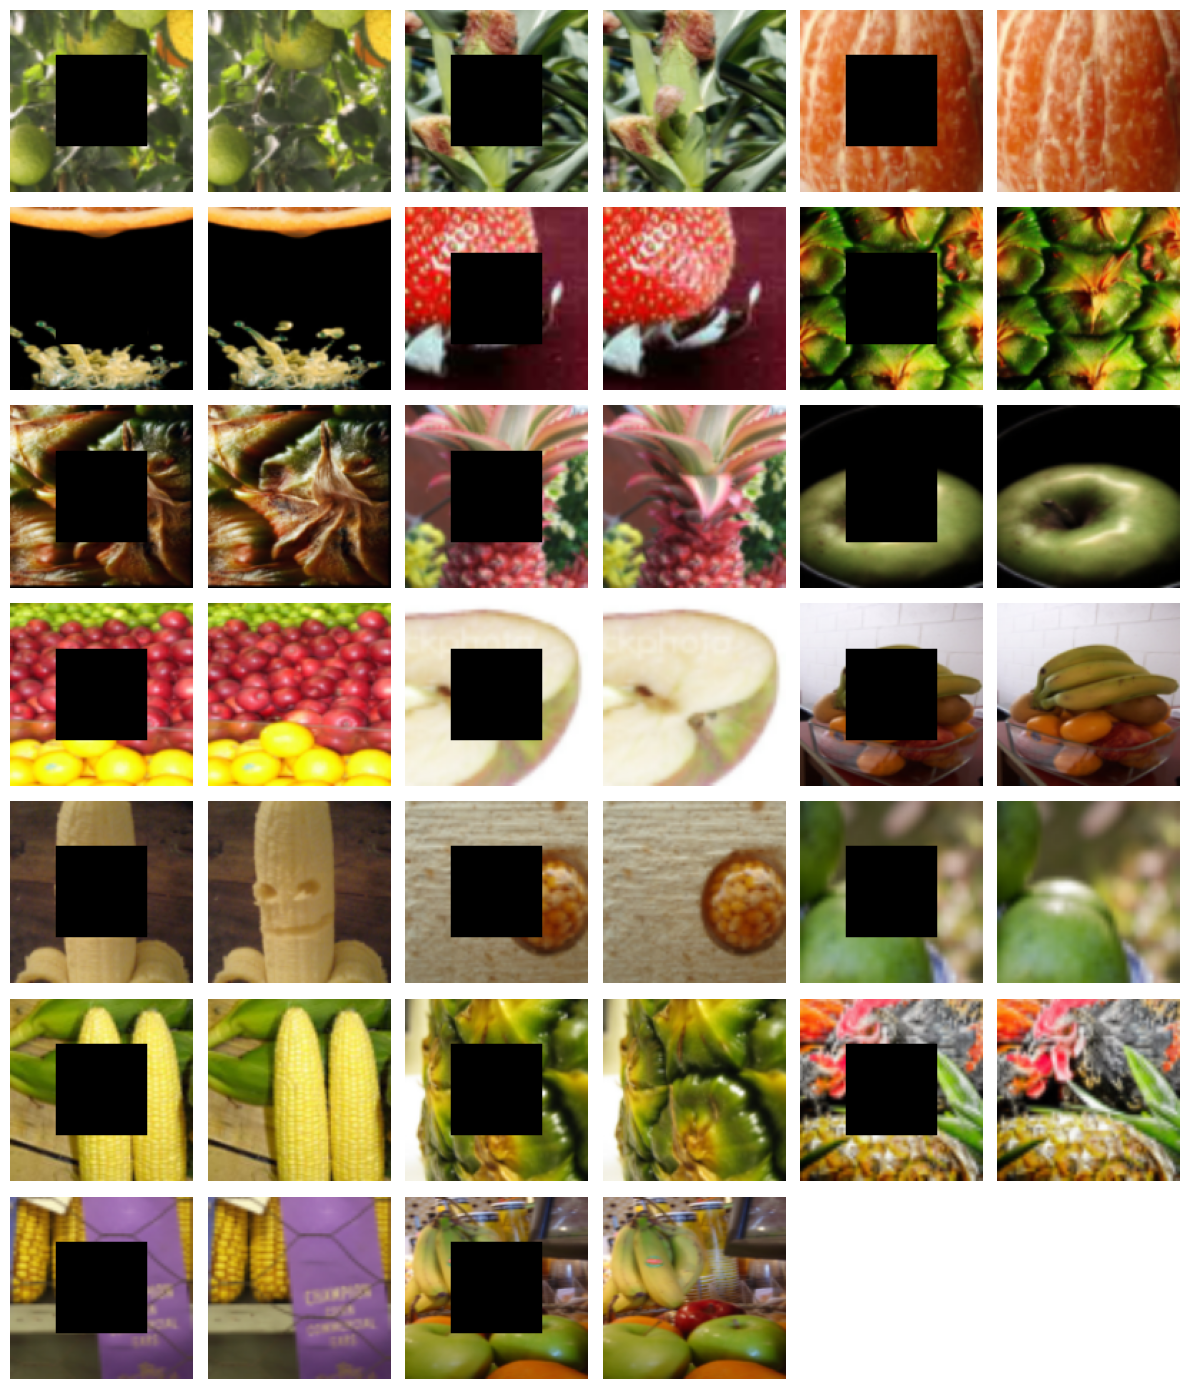

In [19]:
sample_batch = next(iter(train_loader))
sample_cutout, sample_gt, sample_class_idx = sample_batch

def display_sample_batch():
	images = []
	for i in range(20):
		images += [sample_cutout[i], sample_gt[i]]
	display_images(images, images_per_row=6)
display_sample_batch()

# Network

The architecture of our network is inspired by the  the "ContextEncoders" paper. Our model has the following shape (diagram from ContextEncoders)

![Architecture](images/architecture2.png)


Our network has two parts, an Encoder which encodes the context of the image into a 4000 dimensional latent space, and a decoder which decodes points from that latent space into a generated 64x64 infilled area.

In [21]:
LATENT_SPACE_DIM = 4000
HIDDEN_LAYER_SIZE = 64

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
         # (128, 128) -> (64, 64)
        self.conv1 = nn.Conv2d(3, HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  

        # (64, 64) -> (32, 32)
        self.conv2 = nn.Conv2d(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)

        # (32, 32) -> (16, 16)
        self.conv3 = nn.Conv2d(HIDDEN_LAYER_SIZE, 2 * HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  # 16x16 => 8x8

        # (16, 16) -> (8, 8)
        self.conv4 = nn.Conv2d(2 * HIDDEN_LAYER_SIZE, 4 * HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)

        # (8, 8) -> (4, 4)
        self.conv5 = nn.Conv2d(4 * HIDDEN_LAYER_SIZE, 8*HIDDEN_LAYER_SIZE, kernel_size=4, padding=1, stride=2)  # 8x8 => 4x4
        self.flatten = nn.Flatten()

        # (4, 4) -> (Latent Space Dim)
        self.linear = nn.Linear(4*4 * (8* HIDDEN_LAYER_SIZE), LATENT_SPACE_DIM)

    def forward(self, inp):
        inp = F.leaky_relu(self.conv1(inp))
        inp = F.leaky_relu(self.conv2(inp))
        inp = F.leaky_relu(self.conv3(inp))
        inp = F.leaky_relu(self.conv4(inp))
        inp = F.leaky_relu(self.conv5(inp))
        inp = self.flatten(inp)

        inp = F.leaky_relu(self.linear(inp))
        return inp

In [22]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # (LATENT_SPACE_DIM) -> (4 , 4)
        self.linear = nn.Linear(LATENT_SPACE_DIM, 4*4*8*HIDDEN_LAYER_SIZE)

        # (4, 4) -> (8 , 8)
        self.conv_t1 = nn.ConvTranspose2d(8*HIDDEN_LAYER_SIZE, 4*HIDDEN_LAYER_SIZE, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(4*HIDDEN_LAYER_SIZE)

        # (8, 8) -> (16, 16)
        self.conv_t2 = nn.ConvTranspose2d(4*HIDDEN_LAYER_SIZE, 2*HIDDEN_LAYER_SIZE , kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(2*HIDDEN_LAYER_SIZE)

        # (16, 16) -> (32, 32)
        self.conv_t3 = nn.ConvTranspose2d(2*HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(HIDDEN_LAYER_SIZE)

        # (32, 32) -> (64, 64)
        self.conv_t4 = nn.ConvTranspose2d(HIDDEN_LAYER_SIZE, 3, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)



    def forward(self, inp):
        inp = self.linear(inp)

        # Reshape back to image size
        # inp.shape[0] gives the batch size
        # We want a 4x4 image shape 
        inp = inp.reshape(inp.shape[0], -1, 4, 4) 

        inp = self.conv_t1(inp)
        inp = self.batch_norm_1(inp)
        inp = F.relu(inp)

        inp = self.conv_t2(inp)
        inp = self.batch_norm_2(inp)
        inp = F.relu(inp)

        inp = self.conv_t3(inp)
        inp = self.batch_norm_3(inp)
        inp = F.relu(inp)

        inp = self.conv_t4(inp)
        inp = torch.sigmoid(inp)

        return inp

In [26]:
# Use a trained model to create the infilled are for a single image
def predict_fill_area_for_img(img, encoder, decoder):
	img = img.to(device)
	img = img.unsqueeze(0)
	embedding = encoder(img)
	out = decoder(embedding)[0]
	return out.cpu()

# Training 

We train our model using the Adam optimizer with learning rate 0.001. 


For the loss function, we will use an L2 loss between the generated infilling, and the true infilling as was described in the context encoding paper. Later, we will experiment with using different loss functions.

In [27]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

def get_optimizer(encoder, decoder):
    optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
    return optim

l1_loss = nn.L1Loss()
l2_loss = nn.MSELoss()

## Utility Functions For training

In [28]:
## Fill Use the model to fill in 
def get_infilled_image(img, encoder, decoder):
		fill_area = predict_fill_area_for_img(img, encoder, decoder)
		with_center = AddImageCenter(IMAGE_SIZE, CENTER_SIZE)(torch.clone(img), fill_area)
		return with_center

def show_sample_photos(encoder, decoder, title="Sample Batch Photos",):
	images = []
	for sample_image_index in range(0,3):
		cutout_image = sample_cutout[sample_image_index]
		predicted_image = get_infilled_image(cutout_image, encoder, decoder)
		images += [predicted_image, sample_gt[sample_image_index]]
	display_images(images, images_per_row=2, title=title)

def display_loss_history_graph(train_loss_history, val_loss_history, title="Training and Validation Loss" ):
	train_loss_history = np.array(train_loss_history)
	val_loss_history = np.array(val_loss_history)

	plt.plot(train_loss_history[:, 0], train_loss_history[:, 1], label="Training Loss")
	plt.plot(val_loss_history[:, 0], val_loss_history[:, 1], label="Validation Loss")

	plt.title(title)
	plt.xlabel("Epochs")
	plt.ylabel("Loss")
	plt.legend()

### Validation Loss

In [29]:
# Get Validation Loss
def get_val_loss(encoder, decoder, loss_fn):
	with torch.no_grad():
		total_loss = 0
		number_of_images = len(val_loader)
		for batch in val_loader:
				images, gt_images, _ = batch
				images = images.to(device)
				gt_images = gt_images.to(device)

				embeded_images = encoder(images)
				decoded_images = decoder(embeded_images)
				total_loss += loss_fn(get_center_of_image(gt_images), decoded_images).item()
	return total_loss / number_of_images

In [24]:
def do_training(epochs, train_loss_history, val_loss_history, data_loader, optim, encoder, decoder, loss_fn, val_interval = 10, should_save = False):
	best_val = 999999
	for epoch in range(epochs):
		encoder = encoder.to(device)
		decoder = decoder.to(device)
		encoder.train()
		decoder.train()
		
		epoch_loss = 0
		total_number_of_images = len(data_loader)
		pbar = tqdm(enumerate(data_loader), total=total_number_of_images)
		for i, batch in pbar:
			images, gt_images, _ = batch

			images = images.to(device)
			gt_images = gt_images.to(device)

			optim.zero_grad()

			embedded_images = encoder(images)
			decoded_images = decoder(embedded_images)

			loss = loss_fn(get_center_of_image(gt_images), decoded_images)
			loss.backward()
			optim.step()
			epoch_loss += loss.item()

		epoch_loss /= total_number_of_images
		train_loss_history.append([epoch, epoch_loss])
		if epoch % val_interval == 0:
			val_loss = get_val_loss(encoder, decoder, loss_fn)
			print(f"Val Loss: {val_loss}")
			val_loss_history.append([epoch, val_loss])
			if val_loss < best_val and should_save:
				save_model(encoder, decoder, epoch, optim, f"./models/model-{epoch}-{val_loss:.2f}.pth")
				best_val = val_loss

		if epoch % 5 == 0:
			clear_output()
			display_loss_history_graph(train_loss_history, val_loss_history, title="Sanity Training and Validation Loss")
			plt.show()


		print(f"Epoch Loss: {epoch_loss}")

## Do Sanity Check with single image dataset 

In [51]:
sanity_enc = Encoder().to(device)
sanity_dec = Decoder().to(device)
sanity_optim = get_optimizer(sanity_enc, sanity_dec)

### Untrained Model Output

In [37]:
# Get a sample batch of the validation and training data
sample_val_batch_img, sample_val_batch_gt, sample_val_batch_classes = next(iter(val_loader))
sample_train_batch_img, sample_train_batch_gt, sample_train_batch_classes = next(iter(train_loader))
sample_sanity_batch_img, sample_sanity_batch_gt, sample_sanity_batch_class = next(iter(sanity_loader))

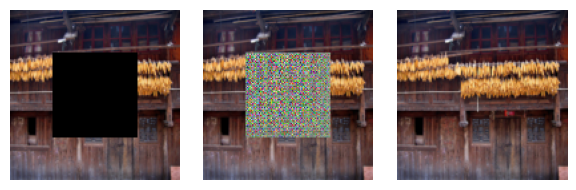

In [45]:
display_images([sample_sanity_batch_img[0], get_infilled_image(sample_sanity_batch_img[0], sanity_enc, sanity_dec), sample_sanity_batch_gt[0]], images_per_row=3)

### Train the sanity model

In [ ]:
# Do the training
sanity_train_loss_history = []
sanity_val_loss_history = []
do_training(
	epochs=50, 
	train_loss_history=sanity_train_loss_history, 
	val_loss_history=sanity_val_loss_history, 
	data_loader=sanity_loader, 
	optim=sanity_optim,
	encoder=sanity_enc, 
	decoder=sanity_dec,
	loss_fn=l2_loss
	)

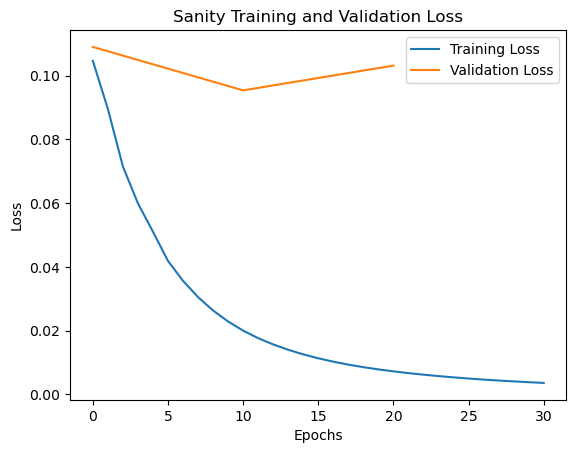

In [53]:
display_loss_history_graph(sanity_train_loss_history, sanity_val_loss_history, title="Sanity Training and Validation Loss")

### Sanity Model Results

We can see that the sanity model learns to perfect reconstruct the infill area as expected, by simply memorizing the image. Note that the left image is the input to the model, the middle is the model generated image, dn the right images is the ground truth image.

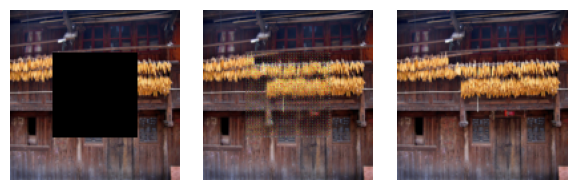

In [54]:
display_images([sample_sanity_batch_img[0], get_infilled_image(sample_sanity_batch_img[0], sanity_enc, sanity_dec), sample_sanity_batch_gt[0]], images_per_row=3)

### Trying to use the sanity model on other images

We can see that the sanity model has simply learned to memorize the sanity infill area and just outputs the same infill area when used with other images.

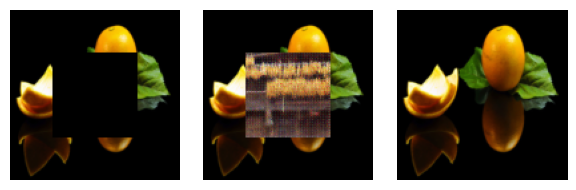

In [55]:
display_images([sample_val_batch_img[0], get_infilled_image(sample_val_batch_img[0], sanity_enc, sanity_dec), sample_val_batch_gt[0]], images_per_row=3)

## Training a full model using L2 Loss
We will now train a full model using the L2 loss.

In [ ]:
l2_enc = Encoder()
l2_dec = Decoder()
l2_optim = get_optimizer(l2_enc, l2_dec)

train_loss_history = []
val_loss_history = []

do_training(
	epochs=5000, 
	train_loss_history=train_loss_history, 
	val_loss_history=val_loss_history, 
	data_loader=train_loader, 
	optim=optim,
	encoder=l2_enc, 
	decoder=l2_dec,
	should_save=True,
	loss_fn=l2_loss
)

### Untrained Model Results

In [ ]:
def display_sample_model_results():
	images = []
	sobel_filter_sample = sobel_filter(sample_batch_img_gt.to(device))

	for i in range(4, 8):
		images += [
									sobel_filter_sample[0].cpu()[i],
									sobel_filter_sample[1].cpu()[i],
									sample_batch_img_gt[i]
									] 
	display_images(images, images_per_row=3, title="Sobel Filter Results")
	display_images(images, images_per_row=3, title="Sobel Filter Results")

In [ ]:
### 

Note since the training was run overnight, we extracted the code in this notebook to a separate python script which we ran to train the network, and which saves the trained model to a file. Thus in this notebook we will load the results from the training runs and display them. Note that the training calls in this notebook do indeed work and our models can be retained by calling the above function.

In [64]:
# Load the model from the overnight training run
load_model(l2_enc, l2_dec, l2_optim, "./L2/l2-model-440-19.67.pth")

In [ ]:

ssim_loss = pytorch_ssim.SSIM()

SSIM_LOSS_RATIO = 0.1

def compute_ssim_loss(output, target):
    ssim_loss = (pytorch_ssim.ssim(output, target) + 1) / 2
    return ssim_loss

def l2andssim_loss(output, target):
    # SSIM is between -1 and 1, add 1 and divide by 2 to get rid of negativies
    return (1- SSIM_LOSS_RATIO)*l2_loss(output, target) + SSIM_LOSS_RATIO*compute_ssim_loss(output, target)

## Better Loss functions that emphasize sharpness

In [ ]:
display_loss_history_graph(sanity_train_loss_history, sanity_val_loss_history, title="Sanity Training and Validation Loss")

In [57]:
class SobelFilter(nn.Module):
    def __init__(self):
        super(SobelFilter, self).__init__()
        self.sobel_filter_x = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)
        self.sobel_filter_y = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)
        sobel_kernel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).broadcast_to((1, 3, 3, 3))
        sobel_kernel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).broadcast_to((1, 3, 3, 3))
        self.sobel_filter_x.weight = nn.Parameter(sobel_kernel_x)
        self.sobel_filter_y.weight = nn.Parameter(sobel_kernel_y)

    def forward(self, image):
        grad_output_x = self.sobel_filter_x(image)
        grad_output_y = self.sobel_filter_y(image)
        return grad_output_x, grad_output_y
sobel_filter = SobelFilter()
sobel_filter = sobel_filter.to(device)

In [ ]:
images = []

sobel_filter_sample = sobel_filter(sample_batch_img_gt.to(device))

for i in range(4, 8):
	images += [
								sobel_filter_sample[0].cpu()[i],
								sobel_filter_sample[1].cpu()[i],
								sample_batch_img_gt[i]
								] 
display_images(images, images_per_row=3, title="Sobel Filter Results")

In [60]:
# Compute a loss based on the difference in edges of the images
def edge_diff_loss(img1, img2):
	grad_x_img_1, grad_y_img_1 = sobel_filter(img1)
	grad_x_img_2, grad_y_img_2 = sobel_filter(img2)

	grad_diff_x = torch.abs(grad_x_img_1 - grad_x_img_2)
	grad_diff_y = torch.abs(grad_y_img_1 - grad_y_img_2)

	loss = torch.mean(grad_diff_x + grad_diff_y)
	return loss

In [ ]:
def l1_and_sharpness_loss(output, target):
    # L1_LAMBDA = 10
    # SHARPNESS_LAMBDA = 0.5
    # SSIM_LAMBDA = 0.8
    L1_LAMBDA = 10
    SHARPNESS_LAMBDA = 0
    SSIM_LAMBDA = 1

    l1_loss_value = l1_loss(output, target)
    edge_diff_loss_value = edge_diff_loss(output, target)
    ssim_loss_value = ssim_loss(output, target)

    # print("L1 Loss:", l1_loss_value)
    # print("Edge Diff Loss:", edge_diff_loss_value)
    # print("SSIM Loss:", ssim_loss_value)
    
    # print("L1 Loss:", L1_LAMBDA * l1_loss_value)
    # print("Edge Diff Loss:", SHARPNESS_LAMBDA * edge_diff_loss_value)
    # print("SSIM Loss:", ssim_loss_value * SSIM_LAMBDA)

    return L1_LAMBDA*l1_loss_value+ SHARPNESS_LAMBDA*edge_diff_loss_value+ SSIM_LAMBDA*ssim_loss_value

sharpness_enc = Encoder()
sharpness_dec = Decoder()

optim = get_optimizer(sharpness_enc, sharpness_dec)

sharpness_train_loss_history = []
sharpness_val_loss_history = []
do_training(
  epochs=10000, 
  train_loss_history=sharpness_train_loss_history, 
  val_loss_history=sharpness_val_loss_history, 
  data_loader=train_loader, 
  optim=optim,
  encoder=sharpness_enc, 
  decoder=sharpness_dec,
  should_save=True,
  loss_fn=l1_and_sharpness_loss
)

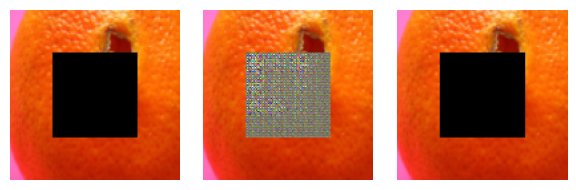

In [62]:
# sanity_img, sanity_gt, sanity_class = next(iter(train_loader))
display_images([sample_train_batch_img[0], get_infilled_image(sample_train_batch_img[0], sharpness_enc, sharpness_dec), sample_train_batch_img[0]], images_per_row=3)

In [69]:
# load_model(sharpness_enc, sharpness_dec, optim, "./models/SSIMOnlymodel-730-1.40.pth")
# load_model(sharpness_enc, sharpness_dec, optim, "./models/only-sharpness-model-130-1.42.pth")
# load_model(sharpness_enc, sharpness_dec, optim, "./models/l1-sharpness-model-710-1.72.pth")
# load_model(sharpness_enc, sharpness_dec, optim, "./models/only-sharpness-model-1850-1.58.pth")
# load_model(sharpness_enc, sharpness_dec, optim, "./models/only-sharpness-model-2010-1.58.pth")
# load_model(sharpness_enc, sharpness_dec, optim, "./models/l2-sharpness-model-3360-0.90.pth")
load_model(sharpness_enc, sharpness_dec, optim, "./models/high-l2-sharpness-model-9770-17.86.pth")

# model-610-1.42.pth

9770

In [ ]:
# indexes = [20, 35, 34, 23, 24]

images = []
for index in range(0, 35):
# for index in indexes:
	images += [sample_train_batch_img[index], get_infilled_image(sample_train_batch_img[index], sharpness_enc, sharpness_dec), sample_train_batch_img_gt[index]]
	# images += [sample_batch_img[index], get_infilled_image(sample_batch_img[index], sharpness_enc, sharpness_dec), sample_batch_img_gt[index]]
display_images(images, images_per_row=3, title="High SSIM Loss Validation Images")

## Visualizing the Latent Space

#### Visualizing the latent space from our Encoder 


In [ ]:
def get_pca(data):
	data = data.numpy()
	pca = PCA(n_components=2)
	data_2d = pca.fit_transform(data)
	return data_2d

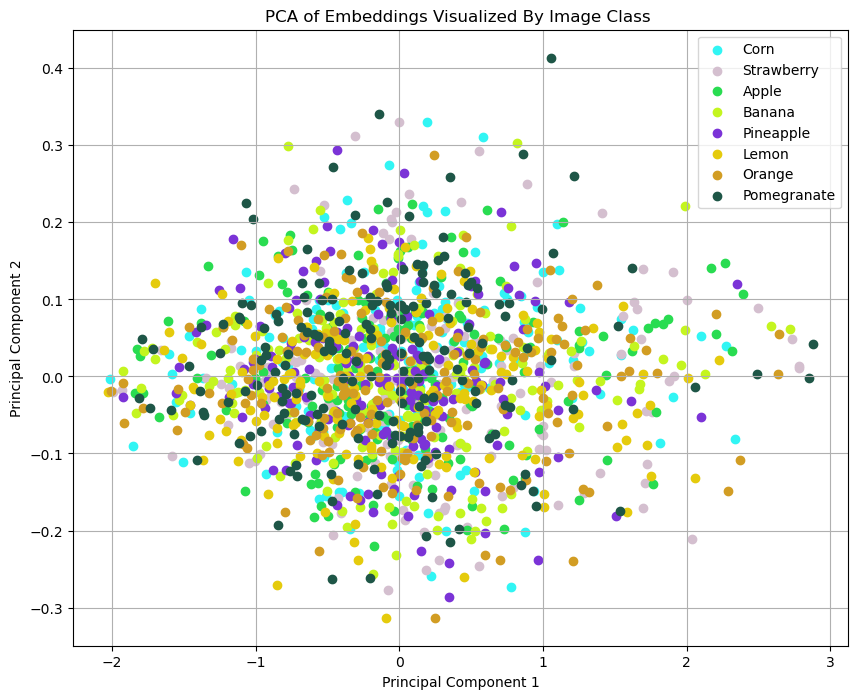

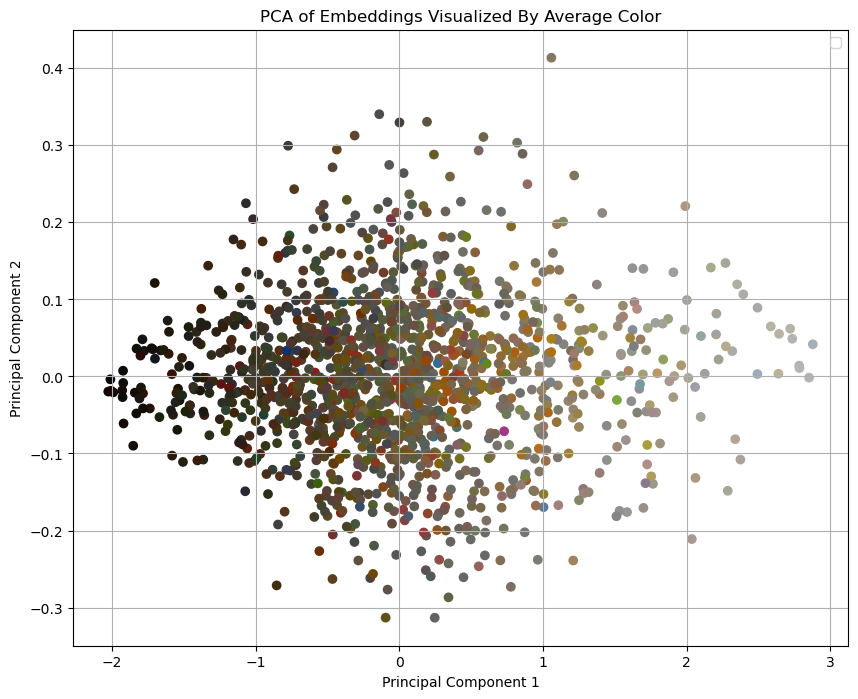

In [ ]:
def visulize_encoder_embeddings(images, classes, encoder, by_class = False):
	with torch.no_grad():
		img_batch = images.to(device)
		embedded = encoder(img_batch).detach().cpu()
		resnet_pca = get_pca(embedded)

		plt.figure(figsize=(10, 8))
		if by_class:
			for idx, name in SELECTED_CLASSES.items():
				r, g, b = torch.rand(3)
				plt.scatter(resnet_pca[classes == idx, 0], resnet_pca[classes == idx, 1], color=[(r, g, b)], label=name)

		else:
			avg_color = torch.mean(images, axis=[2,3])
			avg_color = avg_color.tolist()
			plt.scatter(resnet_pca[:, 0], resnet_pca[:, 1], color=avg_color)

		by_txt = "Image Class " if by_class else "Average Color"
		plt.legend()
		plt.title("PCA of Embeddings Visualized By "+ by_txt  )
		plt.xlabel("Principal Component 1")
		plt.ylabel("Principal Component 2")
		plt.grid(True)
		plt.show()


visulize_encoder_embeddings(sample_batch_img, sample_batch_classes, enc, by_class=True)
visulize_encoder_embeddings(sample_batch_img, sample_batch_classes, enc)

### Visualizing the latent space from ResNet

In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()
        self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

    def forward(self, inp):
        inp = self.resnet.conv1(inp)
        inp = self.resnet.bn1(inp)
        inp = self.resnet.relu(inp)
        inp = self.resnet.maxpool(inp)
        inp = self.resnet.layer1(inp)
        inp = self.resnet.layer2(inp)
        inp = self.resnet.layer3(inp)
        inp = self.resnet.layer4(inp)
        inp = self.resnet.avgpool(inp)
        inp = inp.reshape((-1, 2048))
        return inp

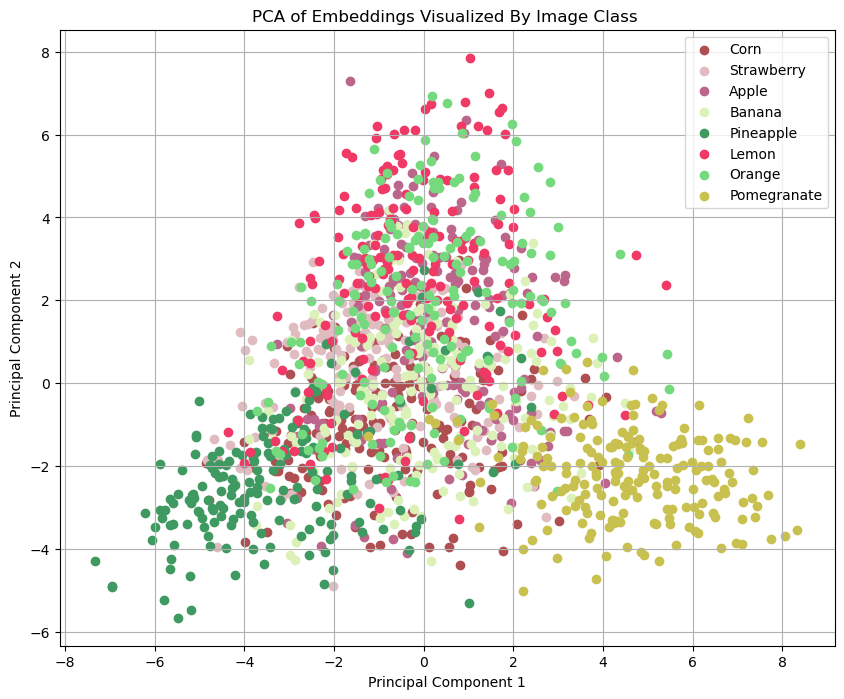

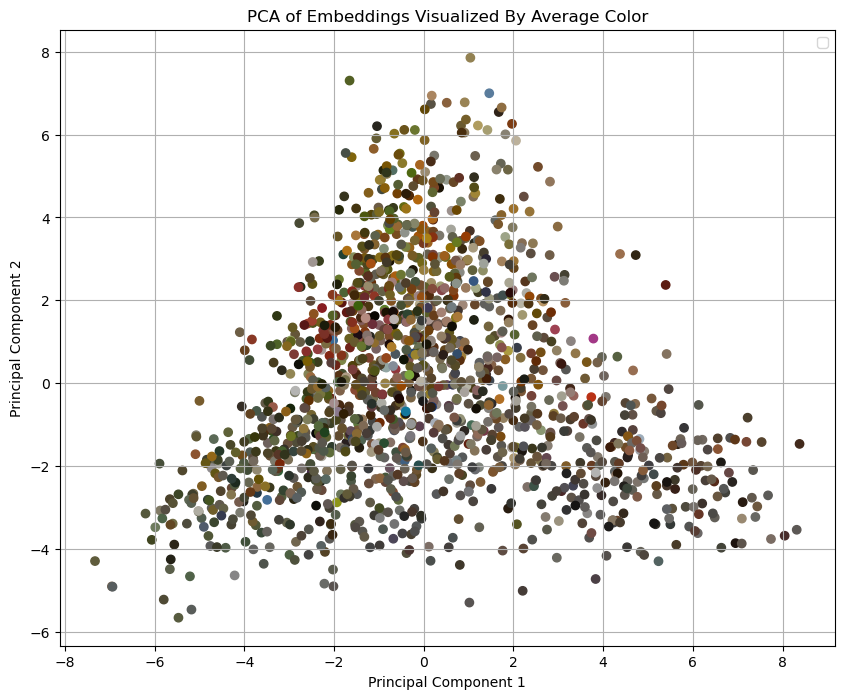

In [ ]:
res_net_encoder = ResNetEncoder()
res_net_encoder = res_net_encoder.to(device)
visulize_encoder_embeddings(sample_batch_img, sample_batch_classes, res_net_encoder, by_class=True)
visulize_encoder_embeddings(sample_batch_img, sample_batch_classes, res_net_encoder)

### Improving Blurryness with Unsharp Masking


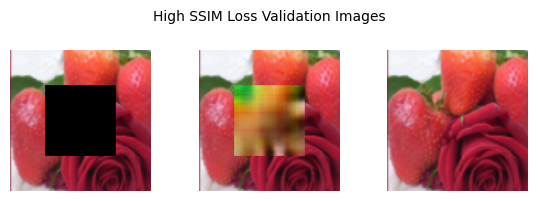

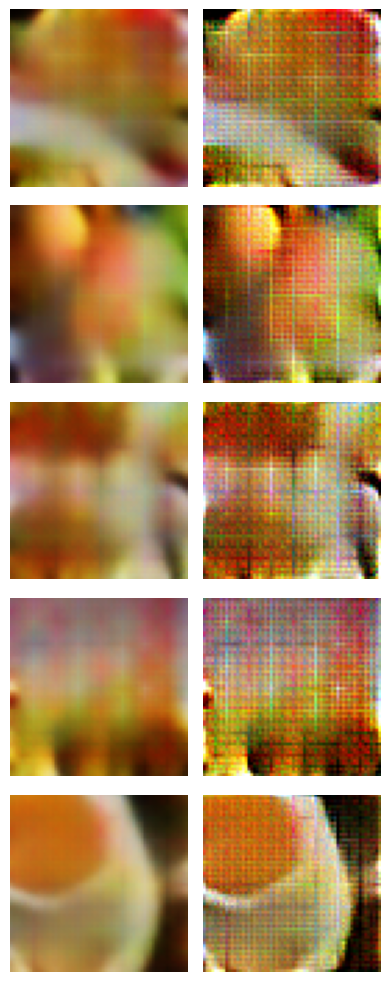

In [67]:
def unsharp_mask(img):
	blurred = torchvision.transforms.GaussianBlur(3, sigma=(7, 7))(img)
	unsharp = img - 1.0*blurred
	sharp = img + 10*unsharp
	return sharp


def get_infilled_image_unsharp_mask(img, encoder, decoder):
		fill_area = predict_fill_area_for_img(img, encoder, decoder)
		sharp_fill_area = unsharp_mask(fill_area)

		sharp_with_center = AddImageCenter(IMAGE_SIZE, CENTER_SIZE)(torch.clone(img), sharp_fill_area)
		with_center = AddImageCenter(IMAGE_SIZE, CENTER_SIZE)(torch.clone(img), fill_area)

		blurred = torchvision.transforms.GaussianBlur(5, sigma=(5, 5))(sharp_with_center)
		return with_center, sharp_with_center, blurred


def visualize_unsharp_mask(encoder, decoder):
	images = []
	for i in range(5, 10):
		fill_area = predict_fill_area_for_img(sample_train_batch_img[i], encoder, decoder)
		unsharped = unsharp_mask(fill_area)
		images += [fill_area, unsharped]
	display_images(images)
visualize_unsharp_mask(sharpness_enc, sharpness_dec)

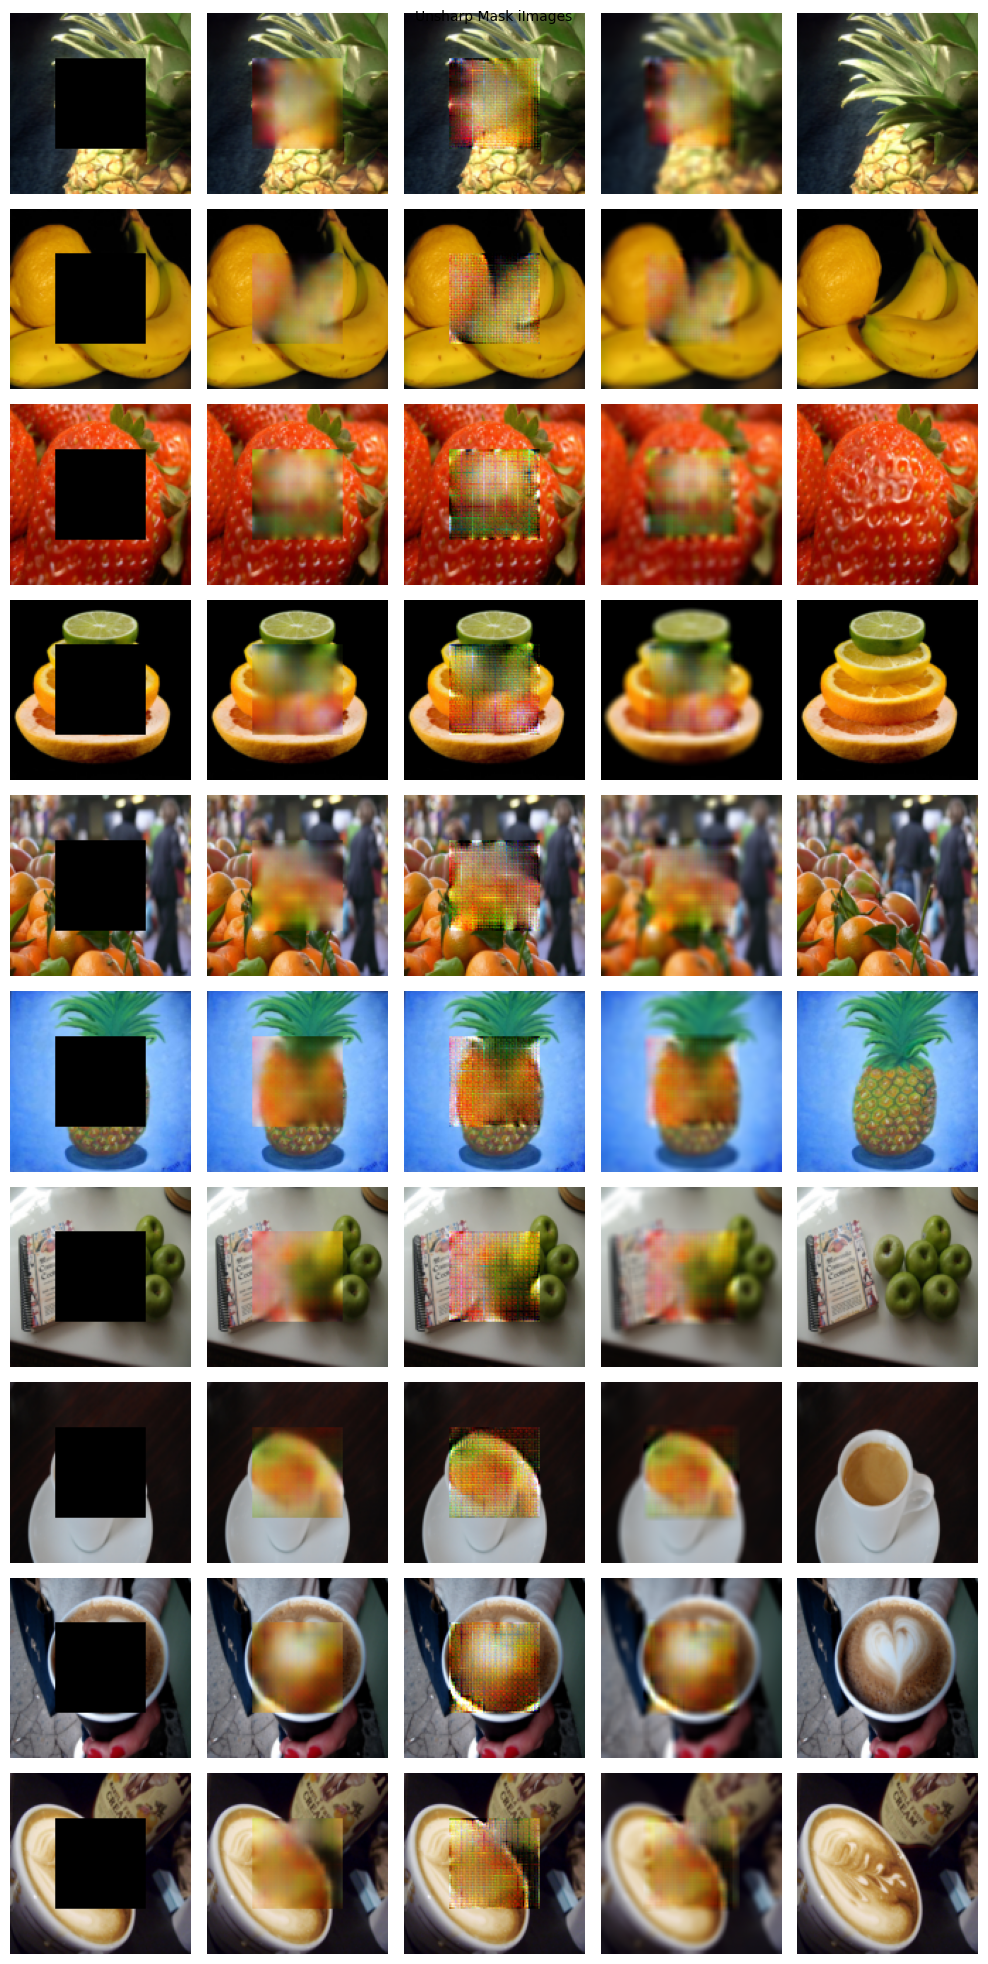

In [68]:
images = []
for index in range(0, 10):
# for index in indexes:
	# img, img_gt,  = sample_train_batch_img[index], sample_train_batch_img_gt[index]
	img, img_gt,  = sample_batch_img[index], sample_batch_img_gt[index]

	sharp, unsharp, blurred = get_infilled_image_unsharp_mask(img, sharpness_enc, sharpness_dec)
	images += [img, sharp, unsharp, blurred, img_gt]
	# images += [sample_batch_img[index], get_infilled_image(sample_batch_img[index], sharpness_enc, sharpness_dec), sample_batch_img_gt[index]]

display_images(images, images_per_row=5, title="Unsharp Mask iImages")